In [1]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# System parameters
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu mol-1
# gamma  = 20                          # ps-1 
# D      = kB * T / mass / gamma       # nm2 ps-1
beta   = 1 / kB / T                  # kJ-1 mol 

### Simulation of double-well potential

Consider the potential 

\begin{eqnarray}
V(x) = (x^2 - 1)^2 \, ,
\end{eqnarray}

with derivative

\begin{eqnarray}
\frac{dV}{dx}  = 4 x (x^2 - 1) \, ,
\end{eqnarray}

and second derivative

\begin{eqnarray}
\frac{d^2V}{dx^2}  = 4(x^2 - 1) + 8x^2\, .
\end{eqnarray}

(-1.0, 2.0)

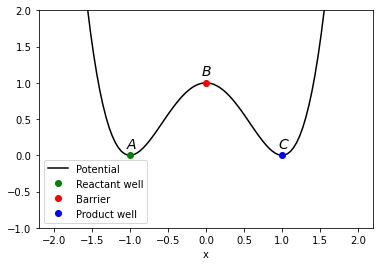

In [24]:
# barrier height
hb = 1    # J nm-1

# Potential
def V(x):
    return hb* ( x ** 2 - 1 ) ** 2            

# First derivative
def dVdx(x):
    return hb * 4 * x * (x ** 2 - 1)                     

# Second derivative
def d2Vdx2(x):
    return hb * 4 * ( x ** 2 - 1 ) + 8 * x ** 2 

xmin       = -2
xmax       =  2
xvalues    = np.linspace(xmin, xmax, 100)
dx         = xvalues[1] - xvalues[0]

xA     = - 1
xB     = 0
xC     = + 1


plt.plot(xvalues, V(xvalues), 'k', linewidth = 1.5, label = 'Potential')
plt.plot(xA, V(xA), 'go', label = 'Reactant well')
plt.text(xA - 0.05 , V(xA) + 0.1 , r'$A$',  fontsize = 14)

plt.plot(xB, V(xB), 'ro', label = 'Barrier') 
plt.text(xB - 0.06 , V(xB) + 0.1 , r'$B$',  fontsize = 14)

plt.plot(xC, V(xC), 'bo', label = 'Product well') 
plt.text(xC - 0.06 , V(xC) + 0.1 , r'$C$',  fontsize = 14)

plt.xlabel("x")
plt.legend()
plt.ylim(-1, 2)

### (Overdamped) Langevin equation
\begin{eqnarray}
dx_t = - \frac{1}{\gamma m} \frac{d}{dx}V(x_t)dt + \sqrt{2 D} \, dB_t
\end{eqnarray}

#### Approximated solution (Euler-Maruyama integrator)

\begin{eqnarray}
x_{k+1} = x_k - \frac{1}{\gamma m} \frac{d}{dx}V(x_k)\Delta t + \sqrt{2 D \Delta t} \, \eta_k
\end{eqnarray}

where $\Delta t$ is the integrator timestep, $m$ is the mass of a particle, $\gamma$ the friction between the particle and the solvent, $D$ is the diffusion constant, $\beta = \frac{1}{k_B T}$ with $k_B$ Boltzmann constant and $\eta_k$ is a random number drawn from a normal distribution (mean = 0 and std = 1).

The diffusion constant, the mass and $\beta$ are related by:

\begin{eqnarray}
D = \frac{k_B T}{\gamma m} = \frac{1}{\beta \gamma m}
\end{eqnarray}

### Mean first passage time
The transition from the left to the right well is a **rare event**. 

The mean first-passage time (MFPT) is the mean time required to go from state $A$ to state $C$ for the first time.

To estimate the MFPT:
1. Generate a trajectory starting in $A$
2. Stop the simulation when the trajectory reach $C$ and saves the elapsed time. Hint: Use a while loop to stop the simulation at $C$.
3. Repeat 1. and 2. for $N$ trajectories and calculate the mean of the saved time periods.

In [6]:
# Number of simulations
N      = 200

# Number of timesteps per each trajectory
#Nsteps = 500

# Timestep for integrator
dt     = 0.005

# Initial position
x0     = -1

gammas = np.array([1, 3, 5, 7])     # ps-1 

# Number of gamma values
Ng     = len(gammas)


# Array where to store the FPTs
# This must be a matrix N x Ng
fpts   = np.zeros((N, Ng))

# for loop to select the gamma value

for g in range(Ng):
    
    # Select gamma from the array gammas
    gamma = gammas[g]
    
    # Calculate diffusion constant
    D     = kB * T / mass / gamma
    
    print("Gamma:", gamma)
    
    # For loop to repeat simulations with the same gamma value
    for r in range(N):
        
        # Set initial position
        x      =  x0

        ## While loop for the integrator
        
        # set index k
        k = 0
        
        # Set correctly the condition for the while loop
        while x < +1: 
            
            # Draw a random number from a normal distribution
            eta  = np.random.normal(0,1,1)
            
            # Implement the integrator
            x    =  x - 1 / gamma / mass * dVdx(x) * dt + np.sqrt( 2 * D * dt ) * eta
            
            # Increment the index k
            k    =  k + 1

        # Save the time of the simulation
        fpts[r,g]  =  k * dt 
    

Gamma: 1
Gamma: 3
Gamma: 5
Gamma: 7


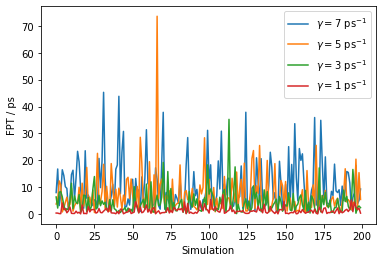

In [17]:
# Plot all trajectories
plt.plot(fpts[:,3], label = r"$\gamma = $" + str(gammas[3]) + " ps$^{-1}$");
plt.plot(fpts[:,2], label = r"$\gamma = $" + str(gammas[2]) + " ps$^{-1}$");
plt.plot(fpts[:,1], label = r"$\gamma = $" + str(gammas[1]) + " ps$^{-1}$");
plt.plot(fpts[:,0], label = r"$\gamma = $" + str(gammas[0]) + " ps$^{-1}$");

plt.xlabel('Simulation')
plt.ylabel('FPT / ps')
plt.legend()

MFPTS: [ 1.352   4.4114  7.2194 10.2535]


Text(0, 0.5, 'MFPT / ps')

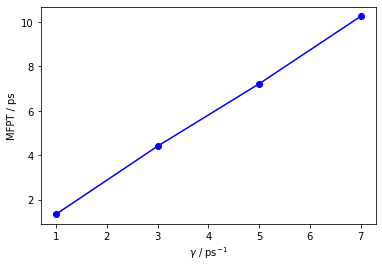

In [20]:
# Calculate the MFPT
mfpt = np.mean(fpts, axis=0)

print("MFPTS:", mfpt)

plt.plot(gammas, mfpt, 'bo-')
plt.xlabel(r"$\gamma$ / ps$^{-1}$")
plt.ylabel(r"MFPT / ps")

### Transition rate

The transition rate is defined as 

$$
k = \frac{1}{MFPT}
$$

MFPTS: [0.73964497 0.22668541 0.13851567 0.09752767]


Text(0, 0.5, '$k$ / ps$^{-1}$')

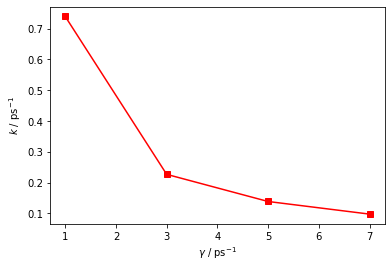

In [19]:
# Calculate the rate
rate_exp = 1 / mfpt

print("MFPTS:", rate_exp)

plt.plot(gammas, rate_exp, 'rs-')
plt.xlabel(r"$\gamma$ / ps$^{-1}$")
plt.ylabel(r"$k$ / ps$^{-1}$")

### Kramers formula 

We now approximate the potential by Taylor expansion around $x_A$ as
$$
    V(x) = V(x_A) + \left. \frac{dV}{dx} \right\vert_{x=x_A} (x-x_A) + \frac{1}{2} \left. \frac{d^2V}{dx^2} \right\vert_{x=x_A} (x-x_A)^2 + ... \, .
$$

Because 

$$
\left. \frac{dV}{dx} \right\vert_{x=x_A}  = 0 \, ,
$$

we can truncate the sum at the second order:
$$
V(x) \approx V(x_A) + \frac{1}{2} \left. \frac{d^2V}{dx^2} \right\vert_{x=x_B} (x-x_A)^2.
$$

This potential is an harmonic potential, where the spring constant is given by the absolute value of the second derivative:

$$
k_{spring} = \left. \left\vert \frac{d^2V}{dx^2} \right\vert_{x=x_A} \right\vert \, ,
$$

then, a particle with mass $m$ oscillates in the well around $x_A$ with frequency

$$
\omega_A =  \sqrt{ \frac{k_{spring}}{m} } = \sqrt{ \frac{1}{m} \left. \left\vert \frac{d^2V}{dx^2} \right\vert_{x=x_A} \right\vert } \,,  
$$

which has units $\mathrm{ps}^{-1}$.

Likewise, the potential can be approximated by a parabola in $x_B$, and we can define the frequency

$$
\omega_B =    \sqrt{ \frac{1}{m} \left. \left\vert \frac{d^2V}{dx^2} \right\vert_{x=x_B}  \right\vert }
$$

#### Kramers formula for high friction regime
According to Kramers theory, the transition rate is

\begin{eqnarray}
k^+
&=&
\frac{\omega_A \omega_B}{2\pi\gamma}\exp\left[-\beta E_b \right] \, ,
\label{eq:KramersHigh2}
\end{eqnarray}

where 

\begin{eqnarray}
E_b  =  V(x_B) - V(x_A)
\end{eqnarray}

is the height of the barrier from the left side.

(-1.0, 2.0)

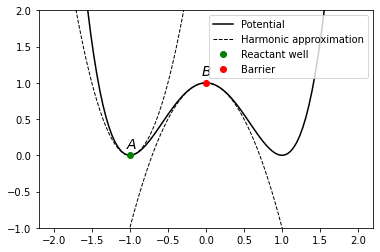

In [25]:
# Approximation at xA and xB
xA           = -1
omegaA       = np.sqrt( 1 / mass * np.abs( d2Vdx2(xA) ) )
kspringA     = np.abs( d2Vdx2(xA) )

xB           =  0
omegaB       = np.sqrt( 1 / mass * np.abs( d2Vdx2(xB) ) )
kspringB     = np.abs( d2Vdx2(xB) )

plt.plot(xvalues, V(xvalues), 'k', linewidth = 1.5, label = 'Potential')
plt.plot(xvalues, 0.5 * kspringA * (xvalues - xA) ** 2 + V(xA), 'k--', linewidth = 1, label = 'Harmonic approximation') 
plt.plot(xA, V(xA), 'go', label = 'Reactant well') 
plt.text(xA - 0.05 , V(xA) + 0.1 , r'$A$',  fontsize = 14)

plt.plot(xvalues, - 0.5 * kspringB * (xvalues - xB) ** 2 + V(xB), 'k--', linewidth = 1)
plt.plot(xB, V(xB), 'ro', label = 'Barrier') 
plt.text(xB - 0.06 , V(xB) + 0.1 , r'$B$',  fontsize = 14)

plt.legend()
plt.ylim(-1, 2)

MFPTS: [0.60295245 0.20098415 0.12059049 0.08613606]


(0.0, 1.0)

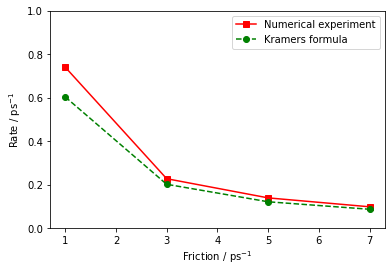

In [32]:
# Define the Kramers formula


def kramersFormula(gamma):
    # Energy barrier
    Eb = V(xB) - V(xA)
    return omegaA * omegaB / 2 / np.pi / gamma * np.exp( - beta * Eb ) 
    
    
rate_kramers = kramersFormula(gammas)

print("MFPTS:", rate_kramers)

plt.plot(gammas, rate_exp,             'rs-', label = 'Numerical experiment')
plt.plot(gammas, rate_kramers, 'go--', label = 'Kramers formula')
plt.xlabel(r"Friction / ps$^{-1}$")
plt.ylabel(r"Rate / ps$^{-1}$")
plt.legend()
plt.ylim(0,1)